In [86]:
# General
import pandas as pd
import numpy as np
from collections import Counter

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# NPL
import re
from textblob import TextBlob
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords 
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import shap

/Users/ruicao/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
# Reading the data
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
# Inspecting the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [5]:
# Drop the first column, which has the duplicate index information
df = df.drop(['Unnamed: 0'],axis=1)

In [6]:
# Fill the missing values with blank on ‘Review Text’ columns 
df['Review Text'].fillna('',inplace=True)

In [7]:
# Create new variables
# review length
df['Character Count']= df['Review Text'].apply(len)

In [8]:
# polarity
df['Polarity score'] = df['Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [9]:
# add sentiment columns
df['Sentiment']=''
df.loc[df['Polarity score']>0,'Sentiment']='Positive'
df.loc[df['Polarity score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity score']<0,'Sentiment']='Negative'

In [10]:
# Basic text cleaning function
def remove_noise(text):
    # Make lowercase and whitespaces
    text = text.str.lower().str.strip()
    # Remove punctuation
    text = text.str.replace('[^\w\s]', '')
    # Remove numbers
    text = text.str.replace('\d+', '')
    return text

In [11]:
# remove noise in the review text
df['Filtered Review']=remove_noise(df['Review Text'])

In [12]:
# tokenized review text
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def lemmatize_text(text):
      return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
def remove_stopwords(text):
    return[w for w in text if not w in stop_words]
df['Filtered Review'] = df['Filtered Review'].astype(str).apply(lemmatize_text)
df['Filtered Review'] = df['Filtered Review'].apply(remove_stopwords)
df['Filtered Review'] = df['Filtered Review'].apply(lambda x: ' '.join(x))

In [13]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Character Count,Polarity score,Sentiment,Filtered Review
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53,0.633333,Positive,absolutely wonderful silky sexy comfortable
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303,0.339583,Positive,love dress sooo pretty happened find store im ...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,500,0.073675,Positive,high hope dress really wanted work initially o...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,124,0.550000,Positive,love love love jumpsuit fun flirty fabulous ev...
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,192,0.512891,Positive,shirt flattering due adjustable front tie perf...


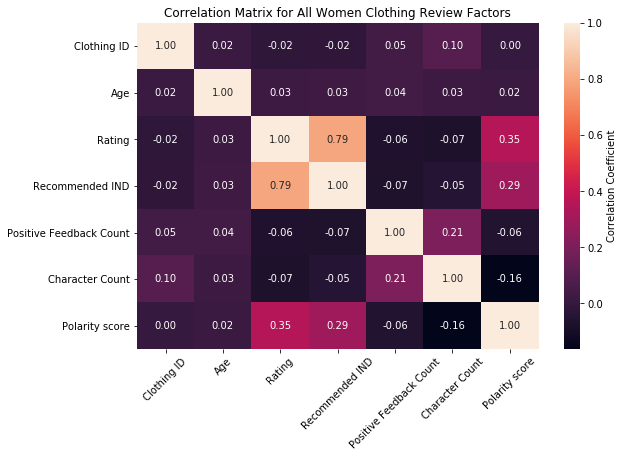

In [14]:
#Correlation Matrix for All Women Clothing Review Factors
plt.figure(figsize=[9,6])
_ = sns.heatmap(df.corr(), annot=True, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix for All Women Clothing Review Factors")
plt.xticks(rotation=45)
plt.show()

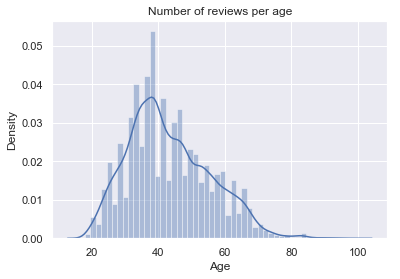

In [15]:
# overall age distribution
sns.set()
sns.distplot(df.Age)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Number of reviews per age')
plt.show()

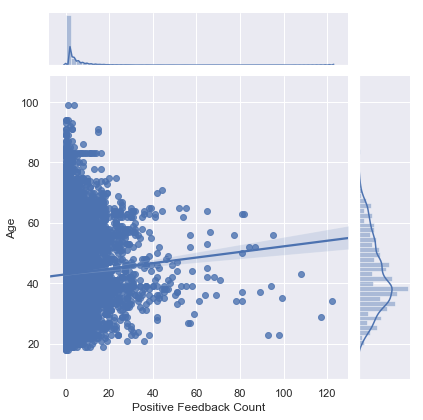

In [94]:
# the relationship between Positive Feedback vs Age
sns.jointplot(df['Positive Feedback Count'],df.Age,kind='reg')
plt.show()

In [17]:
# the total number of clothing ID 
print('the total number of Clothing ID in this dataset is: '+str(len(df['Clothing ID'].value_counts())))

the total number of Clothing ID in this dataset is: 1206


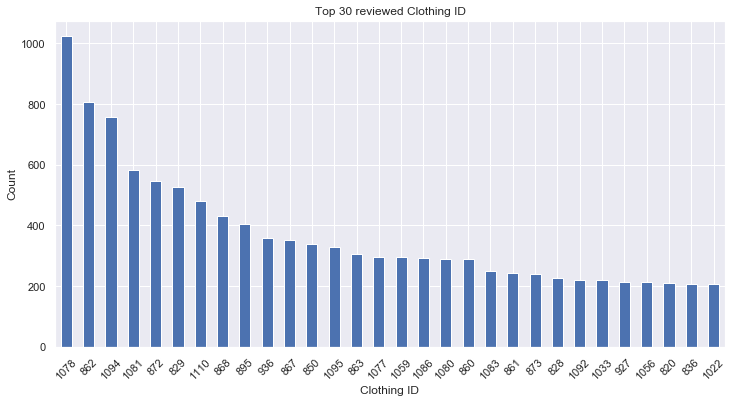

In [18]:
# the top 30 clothing ID
plt.figure(figsize=(12, 6))
df['Clothing ID'].value_counts()[:30].plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel('Clothing ID')
plt.ylabel('Count')
plt.title('Top 30 reviewed Clothing ID')
plt.show()

In [19]:
# find what is the most popular reivewing items
df1=df[df['Clothing ID'].isin([1078,863,1094])]['Class Name'].unique()
print('the most popular riewing items are : '+ str(df1))

the most popular riewing items are : ['Dresses' 'Knits']


In [20]:
# overal infro of the top reivewing items
df[df['Clothing ID'].isin([1078, 862,1094])].describe().drop('count',axis=0).drop('Clothing ID',axis =1)

,Age,Rating,Recommended IND,Positive Feedback Count,Character Count,Polarity score
mean,42.631090,4.198763,0.820959,2.767208,300.522428,0.247592
std,12.110996,1.099646,0.383461,6.679159,152.930079,0.181306
min,18.000000,1.000000,0.000000,0.000000,0.000000,-0.500000
25%,34.000000,4.000000,1.000000,0.000000,176.000000,0.136553
50%,41.000000,5.000000,1.000000,1.000000,297.000000,0.241461
75%,50.000000,5.000000,1.000000,3.000000,457.000000,0.352133
max,99.000000,5.000000,1.000000,98.000000,504.000000,1.000000


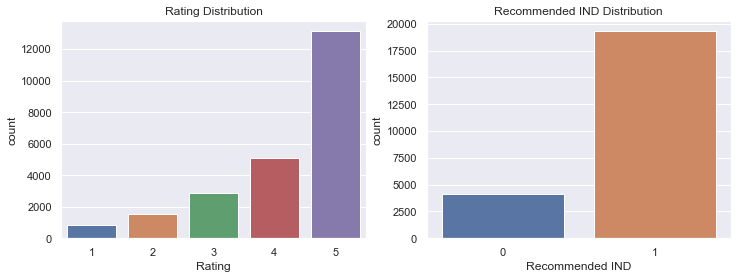

In [21]:
# overall Rating and Recommended IND distribution
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(df.Rating)
plt.title('Rating Distribution')
plt.subplot(1,2,2)
sns.countplot(df['Recommended IND'])
plt.title('Recommended IND Distribution')
plt.show()

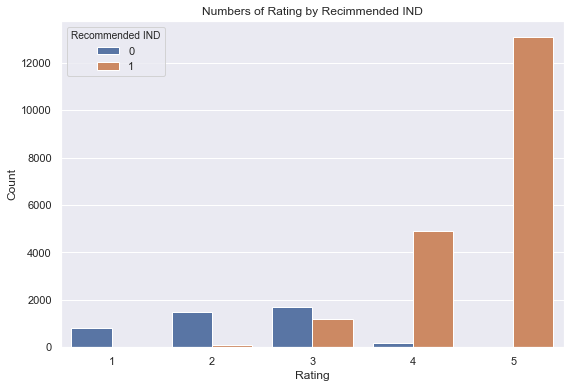

In [22]:
# Numbers of Rating by Recimmended IND
plt.figure(figsize=[9,6])
sns.countplot(x="Rating", hue="Recommended IND",data=df)
plt.title('Numbers of Rating by Recimmended IND')
plt.ylabel("Count")
plt.show()

In [23]:
# The Not recommend Portion
dislike = df['Recommended IND'].value_counts()[0]/(df['Recommended IND'].value_counts()[0]+df['Recommended IND'].value_counts()[1])
print('The Not recommend Portion in this datset is : '+str(dislike))

The Not recommend Portion in this datset is : 0.17763774163331347


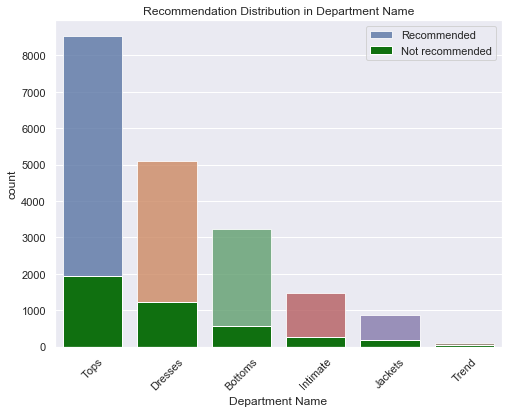

In [24]:
plt.figure(figsize = ((8,6)))
recommended = df[df['Recommended IND'] ==1]
not_recommended = df[df['Recommended IND']==0]
sns.countplot(recommended['Department Name'], order=df["Department Name"].value_counts().index,alpha=0.8, label = 'Recommended')
sns.countplot(not_recommended['Department Name'],order = df["Department Name"].value_counts().index,color= 'green',label='Not recommended')
plt.xticks(rotation=45)
plt.legend(loc= 'upper right')
plt.title('Recommendation Distribution in Department Name')
plt.show()

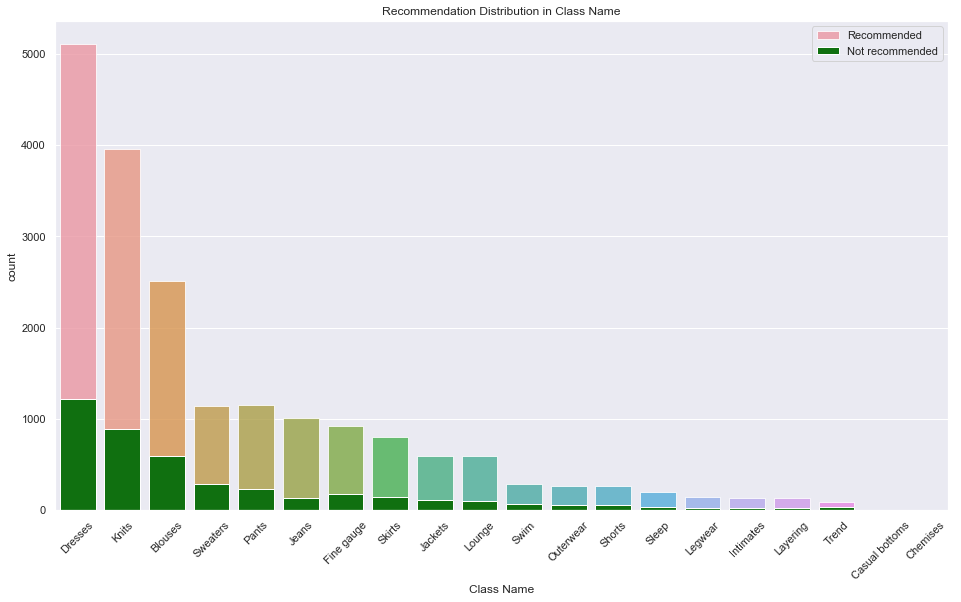

In [25]:
plt.figure(figsize = ((16,9)))
sns.countplot(recommended['Class Name'], order=df["Class Name"].value_counts().index,alpha=0.8, label = 'Recommended')
sns.countplot(not_recommended['Class Name'],order = df["Class Name"].value_counts().index,color= 'green',label='Not recommended')
plt.xticks(rotation=45)
plt.legend(loc= 'upper right')
plt.title('Recommendation Distribution in Class Name')
plt.show()

In [26]:
# reviw length in rating
rating = df.groupby(['Rating'])['Character Count'].count()
rating

Rating
1      842
2     1565
3     2871
4     5077
5    13131
Name: Character Count, dtype: int64

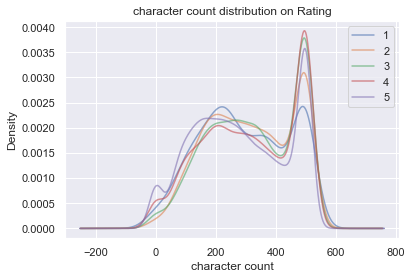

In [27]:
# review length distribution on Rating
df.groupby('Rating')['Character Count'].plot(kind = 'density',alpha=0.6)
plt.legend()
plt.xlabel('character count')
plt.title('character count distribution on Rating')
plt.show()

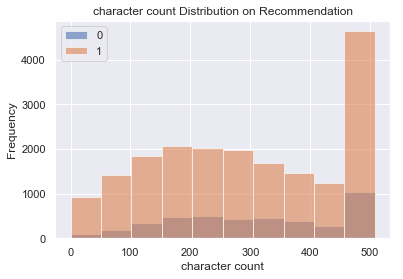

In [28]:
# review length distribution on Recommendation
df.groupby('Recommended IND')['Character Count'].plot(kind = 'hist',alpha = 0.6)
plt.legend()
plt.xlabel('character count')
plt.title('character count Distribution on Recommendation')
plt.show()

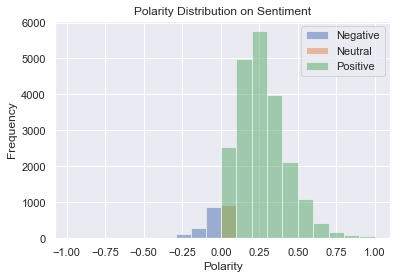

In [29]:
# sentiment analysis
df.groupby('Sentiment')['Polarity score'].plot(kind = 'hist',alpha=0.5)
plt.legend()
plt.title('Polarity Distribution on Sentiment')
plt.xlabel('Polarity')
plt.show()

In [30]:
# initialize the vectorizer
count = CountVectorizer(stop_words='english',min_df=.005,ngram_range=(1,2))
count.fit(df['Filtered Review'])
len(count.vocabulary_)

887

In [31]:
#transform the document into a bag of words
bag_of_words = count.transform(df['Filtered Review'])

In [32]:
# check the top 25 most common terms
occ = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': count.get_feature_names(), 'occurrences': occ})
count_top_25 = counts_df.sort_values(by='occurrences', ascending=False).head(25)

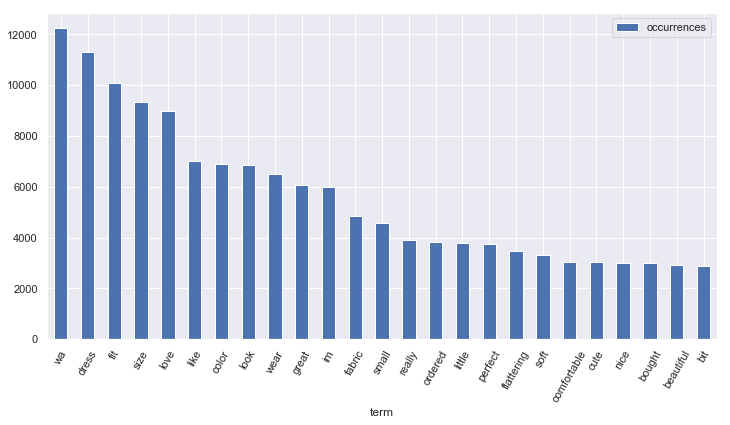

In [33]:
# plot the top 25 most common terms
fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(12,6))
count_top_25.plot(ax=axes,kind='bar',x='term')
plt.xticks(rotation=60)
plt.show()

In [34]:
# use the TfidfTransformer to calculate the weights for each term
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(bag_of_words)

In [35]:
# check the top 25 most common terms by average ti-idf weight
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': count.get_feature_names(), 'weight': weights})
weight_top_25= weights_df.sort_values(by='weight', ascending=False).head(25)

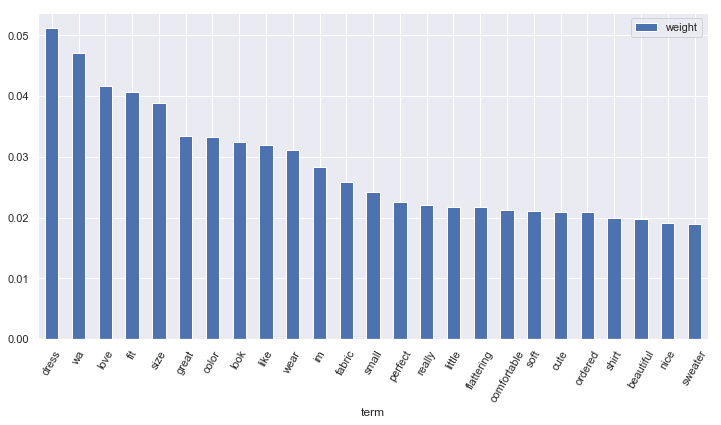

In [36]:
# plot the top 25 most common terms by average ti-idf weight
fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(12,6))
weight_top_25.plot(ax=axes,kind='bar',x='term')
plt.xticks(rotation=60)
plt.show()

In [37]:
# set X,y value
X = transformed_weights
y = df['Recommended IND']

In [38]:
# train-test split
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size = 0.2, random_state=42)

# Navie Bayes

In [47]:
# GridSearch
param_gird = {'alpha':[.1, 1, 5, 10, 50]}
classifier = MultinomialNB()
classifier=GridSearchCV(classifier, param_gird,scoring = "accuracy",cv = 5)
classifier.fit(X_train, y_train)
print('best parameter{}:'.format(classifier.best_params_),'best score {}:'.format(classifier.best_score_))

best parameter{'alpha': 0.1}: best score 0.866191185863317:


In [65]:
# fit the data with best model
classifier = MultinomialNB(alpha = 0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

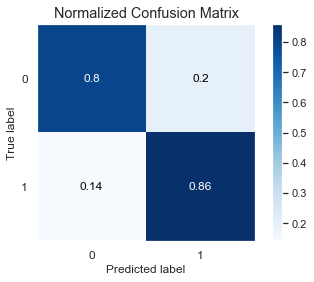

In [66]:
# confusion_matrix
skplt.metrics.plot_confusion_matrix(classifier.predict(X_test), y_test, normalize=True)
plt.show()

In [67]:
# classification report
print(classification_report(classifier.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.29      0.80      0.43       310
           1       0.98      0.86      0.92      4388

    accuracy                           0.86      4698
   macro avg       0.64      0.83      0.67      4698
weighted avg       0.94      0.86      0.89      4698



# Logistic Regression

In [54]:
# GirdSearch
param_gird = {'C':[.1, 1, 5, 10, 50]}
logreg = LogisticRegression()
logreg = GridSearchCV(logreg, param_gird,scoring = "accuracy",cv = 5)
logreg.fit(X_train, y_train)
print('best parameter{}:'.format(logreg.best_params_),'best score {}:'.format(logreg.best_score_))

/Users/ruicao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best parameter{'C': 5}: best score 0.8873749201618054:


In [68]:
# fit the data with best model
logreg = LogisticRegression(C = 5)
logreg.fit(X_train, y_train)

/Users/ruicao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

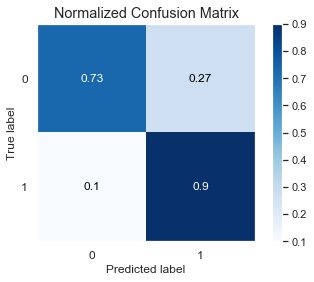

In [69]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(logreg.predict(X_test), y_test, normalize=True)
plt.show()

In [70]:
# classification report
print(classification_report(logreg.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.54      0.73      0.62       624
           1       0.96      0.90      0.93      4074

    accuracy                           0.88      4698
   macro avg       0.75      0.82      0.77      4698
weighted avg       0.90      0.88      0.89      4698



# Random Froest

In [62]:
# Random Froest
model_rf = RandomForestClassifier()
model_rf.fit(X_train,y_train)

/Users/ruicao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

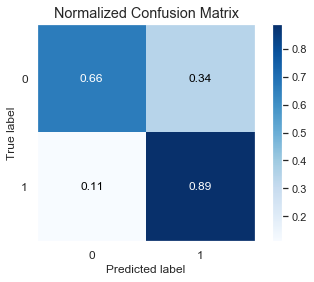

In [72]:
skplt.metrics.plot_confusion_matrix(Random.predict(X_test), y_test, normalize=True)
plt.show()

In [71]:
print(classification_report(model_rf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.48      0.62      0.54       655
           1       0.94      0.89      0.91      4043

    accuracy                           0.85      4698
   macro avg       0.71      0.76      0.73      4698
weighted avg       0.87      0.85      0.86      4698



In [75]:
df['Recommended IND'].value_counts()

1    19314
0     4172
Name: Recommended IND, dtype: int64

# SMOTE 

In [77]:
# Resampling data using SMOTE method 
smote=SMOTE()
X_sm, y_sm = smote.fit_sample(X,y)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

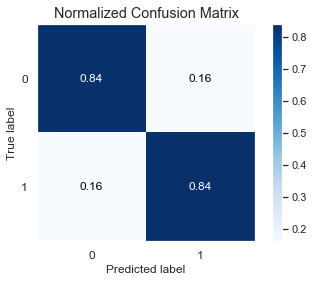

In [78]:
# Naive Bayes
classifier = MultinomialNB(alpha = 0.1)
classifier.fit(X_train_sm, y_train_sm)
# confusion_matrix
skplt.metrics.plot_confusion_matrix(classifier.predict(X_test_sm), y_test_sm, normalize=True)
plt.show()

In [80]:
# classification report
print(classification_report(classifier.predict(X_test_sm), y_test_sm))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3935
           1       0.83      0.84      0.84      3791

    accuracy                           0.84      7726
   macro avg       0.84      0.84      0.84      7726
weighted avg       0.84      0.84      0.84      7726



/Users/ruicao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


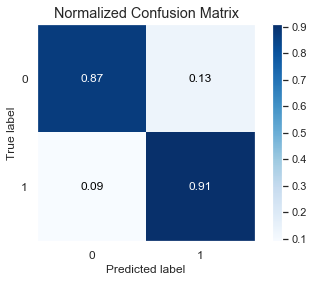

In [81]:
#logistic regression
model = LogisticRegression(C=5)
model.fit(X_train_sm, y_train_sm)
# confusion_matrix
skplt.metrics.plot_confusion_matrix(model.predict(X_test_sm), y_test_sm, normalize=True)
plt.show()

In [82]:
#classification report
print(classification_report(model.predict(X_test_sm), y_test_sm))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      4123
           1       0.86      0.91      0.88      3603

    accuracy                           0.89      7726
   macro avg       0.89      0.89      0.89      7726
weighted avg       0.89      0.89      0.89      7726



/Users/ruicao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


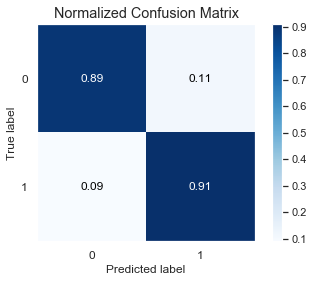

In [83]:
# Random Forest
Random = RandomForestClassifier()
Random.fit(X_train_sm,y_train_sm)
# confusion_matrix
skplt.metrics.plot_confusion_matrix(Random.predict(X_test_sm), y_test_sm, normalize=True)
plt.show()

In [84]:
# classiification report
print(classification_report(Random.predict(X_test_sm), y_test_sm))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      3990
           1       0.89      0.91      0.90      3736

    accuracy                           0.90      7726
   macro avg       0.90      0.90      0.90      7726
weighted avg       0.90      0.90      0.90      7726



# SHAP with Logistic Regression

In [87]:
shap.initjs()

In [88]:
model = LogisticRegression(C=5)
model.fit(X_train_sm, y_train_sm)

/Users/ruicao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
explainer = shap.LinearExplainer(model,X_train_sm,feature_dependence="independent")

In [90]:
shap_values = explainer.shap_values(X_test_sm)

In [91]:
X_test_array = X_test_sm.toarray()

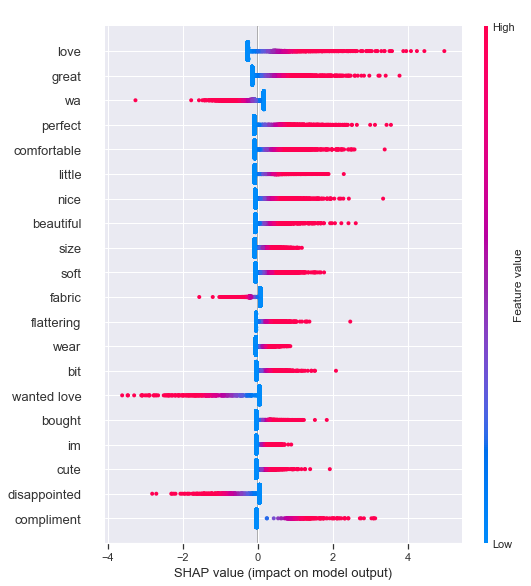

In [92]:
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=count.get_feature_names())

In [93]:
ind = -1
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=count.get_feature_names()
)
